Codes

##install necessary libraries


In [ ]:
# %pip install tensorflow transformers datasets nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split


##Using Pandas to load the dataset and Check if there is any missing values

In [8]:
import pandas as pd

# Load the data
data_path = 'data/Spam_SMS.csv'
df = pd.read_csv(data_path)

# Check for missing values and class distribution
print(df.isnull().sum())
print(df['Class'].value_counts())

Class      0
Message    0
dtype: int64
Class
ham     1881
spam    1547
Name: count, dtype: int64


##Text Preprocessing

In [41]:
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define stopwords set
stop_words = set(stopwords.words('english'))

# Preprocessing Function
def preprocess_message(message):
    message = message.lower() # Lowercase and remove punctuation
    tokens = nltk.word_tokenize(message)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(tokens)  # Join tokens back into a string

# Split the data first
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])  # Stratify ensures balanced classes
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['Class'])

# Preprocess Messages
train_df['Message'] = train_df['Message'].apply(preprocess_message)
val_df['Message'] = val_df['Message'].apply(preprocess_message)
test_df['Message'] = test_df['Message'].apply(preprocess_message)

# Print dataset sizes
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 2467
Validation set size: 275
Test set size: 686


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['Class'])
val_labels = label_encoder.transform(val_df['Class'])
test_labels = label_encoder.transform(test_df['Class'])


In [43]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Initialize the TextVectorization layer
max_features = 10000  # Number of unique words to consider
sequence_length = 128  # Length of each input sequence

vectorizer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=sequence_length)

# Adapt the TextVectorization layer on the training data (this learns the vocabulary)
vectorizer.adapt(train_df['Message'])

# Now transform the data using the adapted vectorizer
train_texts = vectorizer(train_df['Message'])
val_texts = vectorizer(val_df['Message'])
test_texts = vectorizer(test_df['Message'])



In [44]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=sequence_length),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Change to 'softmax' if more than 2 classes
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use 'sparse_categorical_crossentropy' for multi-class


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [45]:
history = model.fit(train_texts, train_labels, validation_data=(val_texts, val_labels), epochs=20, batch_size=16)


Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5185 - loss: 0.6902 - val_accuracy: 0.5491 - val_loss: 0.6802
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5755 - loss: 0.6726 - val_accuracy: 0.7273 - val_loss: 0.6537
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6762 - loss: 0.6182 - val_accuracy: 0.9455 - val_loss: 0.4064
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9018 - loss: 0.3297 - val_accuracy: 0.9455 - val_loss: 0.1890
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9437 - loss: 0.1794 - val_accuracy: 0.9636 - val_loss: 0.1375
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9768 - loss: 0.0988 - val_accuracy: 0.9455 - val_loss: 0.1360
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9735 - loss: 0.0823 - val_accuracy: 0.9673 - val_loss: 0.1142
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9608 - loss: 0.1071 - val_accuracy: 0.

In [46]:
test_loss, test_accuracy = model.evaluate(test_texts, test_labels)
print(f"Test Accuracy: {test_accuracy}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9673 - loss: 0.0867 
Test Accuracy: 0.9562682509422302


In [47]:
predictions = model.predict(test_texts)
predictions = (predictions > 0.5).astype(int)

# Print predictions alongside original messages and true labels
test_df['Predicted'] = predictions  # Add predictions to the test DataFrame
test_df['True'] = test_labels  # Add true labels to the test DataFrame

# Display the original messages along with their predicted and true labels
print(test_df[['Message', 'True', 'Predicted']].tail(10))  # Print the first 10 rows


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                                                Message  True  Predicted
2235  get free trial subscription premium service of...     1          1
1284  dont prize go another customer tc wwwtcbiz 18 ...     1          1
1581  dearregret cudnt pick calldrove frm ctla cochi...     0          0
1768  limited time offer get 62 products use code sp...     1          1
864   limited time offer get 25 products use code sp...     1          1
596                 yo game almost want go walmart soon     0          0
3211  poyyarikaturkolathupalayamunjalur posterode di...     0          0
1749                 easy ahsen got selected means good     0          0
849                                  taste fish curry p     0          0
534                                unbelievable faglord     0          0


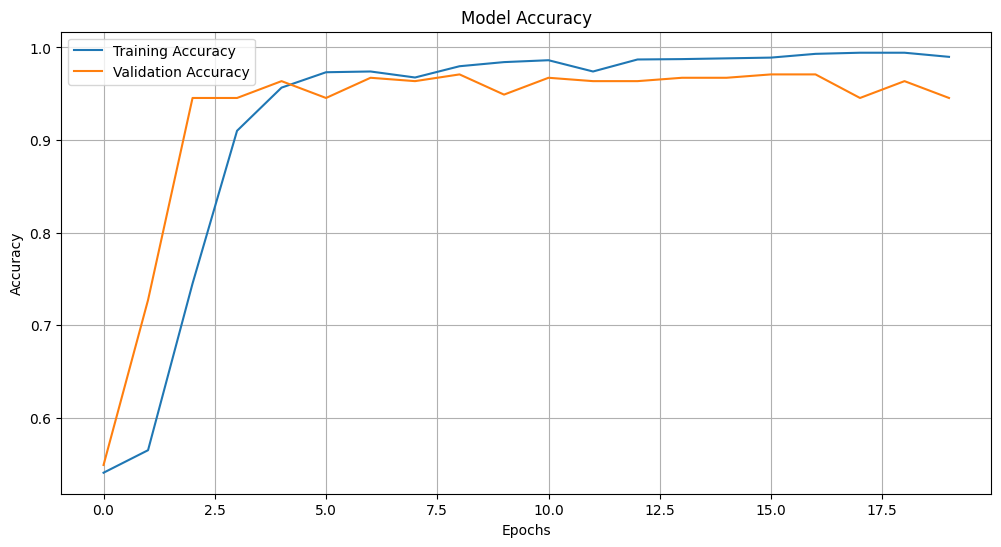

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
model.save("C:/Users/USER/Documents/CSB/model/spam_classifier.keras")